In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
texture_1 = plt.imread('../data/texture1.jpg').astype(np.float32)
h, w, c = texture_1.shape
block_size = 75
assert block_size < min(h, w)
y_max, x_max = h - block_size, w - block_size
dh = h * 2
dw = w * 2
nx_blocks = ny_blocks = max(dh, dw) // block_size
w_new = h_new = nx_blocks * block_size
n_blocks = nx_blocks * ny_blocks
xs = np.arange(x_max)
ys = np.arange(y_max)
all_blocks = [texture_1[y:y + block_size, x:x + block_size] for x in xs for y in ys]
n_rc = int(block_size / 6)

In [3]:
# normalize_img normalizes our output to be between 0 and 1
def normalize_img(im):
    img = im.copy()
    img += np.abs(np.min(img))
    img /= np.max(img)
    return img

In [4]:
patch_1 = all_blocks[0]
patch_2 = all_blocks[1743]
patch_3 = all_blocks[7286]

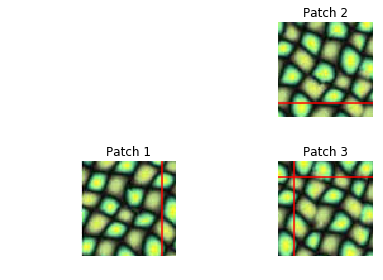

In [5]:
fig, ax = plt.subplots(2, 2)
ax[0,0].axis('off')

ax[1,0].imshow(normalize_img(patch_1))
ax[1,0].axvline(x=block_size - n_rc, color='red')
ax[1,0].axis('off')
ax[1,0].set_title('Patch 1')

ax[0,1].imshow(normalize_img(patch_2))
ax[0,1].axhline(y=block_size - n_rc, color='red')
ax[0,1].axis('off')
ax[0,1].set_title('Patch 2')

ax[1,1].imshow(normalize_img(patch_3))
ax[1,1].axvline(x=n_rc, color='red')
ax[1,1].axhline(y=n_rc, color='red')
ax[1,1].axis('off')
ax[1,1].set_title('Patch 3')

plt.tight_layout()
plt.show()

In [6]:
b1 = patch_1[:, -n_rc:]
b2 = patch_2[-n_rc:, :]
b3 = patch_3[:, :n_rc]
b4 = patch_3[:n_rc, :]

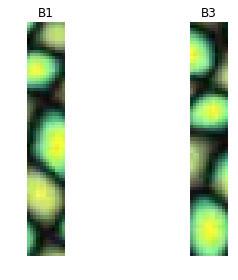

In [7]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(normalize_img(b1))
ax[0].axis('off')
ax[0].set_title('B1')

ax[1].imshow(normalize_img(b3))
ax[1].axis('off')
ax[1].set_title('B3')

plt.tight_layout()
plt.show()

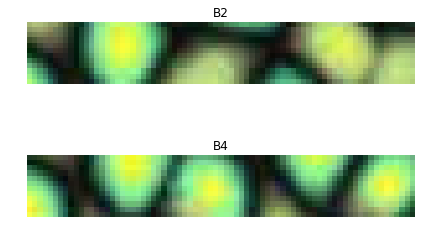

In [8]:
fig, ax = plt.subplots(2, 1)

ax[0].imshow(normalize_img(b2))
ax[0].axis('off')
ax[0].set_title('B2')

ax[1].imshow(normalize_img(b4))
ax[1].axis('off')
ax[1].set_title('B4')

plt.tight_layout()
plt.show()

In [9]:
# compute sum of squared deviations:
error_surf_vert = np.sum((b1 - b3) ** 2, axis=2)
error_surf_hor = np.sum((b2 - b4) ** 2, axis=2)

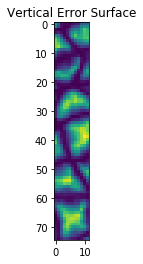

In [10]:
plt.title('Vertical Error Surface')
plt.imshow(normalize_img(error_surf_vert))
plt.show()

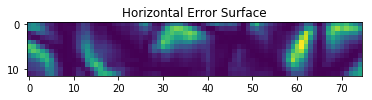

In [11]:
plt.title('Horizontal Error Surface')
plt.imshow(normalize_img(error_surf_hor))
plt.show()

In [12]:
# compute min paths
top_min_path = np.zeros((block_size), dtype=np.int)
left_min_path = np.zeros((block_size), dtype=np.int)

top_min_path[0] = np.argmin(error_surf_vert[0, :], axis=0)
left_min_path[0] = np.argmin(error_surf_hor[:, 0], axis=0)
for i in range(1, block_size):
    err_mid_v = error_surf_vert[i, :]
    err_mid_h = error_surf_hor[:, i]
    mid_v = err_mid_v[top_min_path[i - 1]]
    mid_h = err_mid_h[left_min_path[i - 1]]
    
    err_left = np.roll(error_surf_vert[i, :], 1, axis=0)
    err_top = np.roll(error_surf_hor[:, i], 1, axis=0)
    err_left[0] = err_top[0] = np.inf
    left = err_left[top_min_path[i - 1]]
    top = err_top[left_min_path[i - 1]]
    
    err_right = np.roll(error_surf_vert[i, :], -1, axis=0)
    err_bot = np.roll(error_surf_hor[:, i], -1, axis=0)
    err_right[-1] = err_bot[-1] = np.inf
    right = err_right[top_min_path[i - 1]]
    bot = err_bot[left_min_path[i - 1]]
    
    next_poss_pts_v = np.vstack((left, mid_v, right))
    next_poss_pts_h = np.vstack((top, mid_h, bot))
    
    new_pts_ind_v = top_min_path[i - 1] + (np.argmin(next_poss_pts_v, axis=0) - 1)
    new_pts_ind_h = left_min_path[i - 1] + (np.argmin(next_poss_pts_h, axis=0) - 1)
    top_min_path[i] = new_pts_ind_v
    left_min_path[i] = new_pts_ind_h

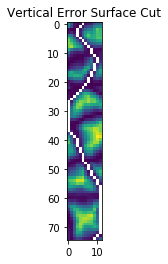

In [13]:
vert_err_cut = error_surf_vert.copy()
yy, xx = np.meshgrid(np.arange(block_size), np.arange(n_rc))
vert_path_mask = xx.T ==  np.tile(np.expand_dims(top_min_path, 1), n_rc)
vert_err_cut[vert_path_mask] = np.nan
plt.title('Vertical Error Surface Cut')
plt.imshow(vert_err_cut)
plt.show()

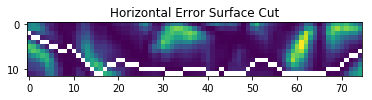

In [14]:
hor_err_cut = error_surf_hor.copy()
yy, xx = np.meshgrid(np.arange(block_size), np.arange(n_rc))
hor_path_mask = (xx.T ==  np.tile(np.expand_dims(left_min_path, 1), n_rc)).T
hor_err_cut[hor_path_mask] = np.nan
plt.title('Horizontal Error Surface Cut')
plt.imshow(hor_err_cut)
plt.show()

In [15]:
hor_overlap = error_surf_hor[:, :n_rc].copy()
vert_overlap = error_surf_vert[:n_rc].copy()
error_surf_vert[:n_rc, :] += hor_overlap
error_surf_hor[:, :n_rc] += vert_overlap

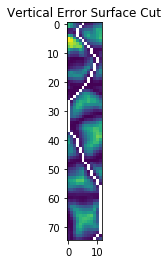

In [16]:
vert_err_cut = error_surf_vert.copy()
yy, xx = np.meshgrid(np.arange(block_size), np.arange(n_rc))
vert_path_mask = xx.T ==  np.tile(np.expand_dims(top_min_path, 1), n_rc)
vert_err_cut[vert_path_mask] = np.nan
plt.title('Vertical Error Surface Cut')
plt.imshow(vert_err_cut)
plt.show()

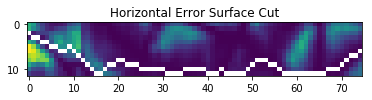

In [17]:
hor_err_cut = error_surf_hor.copy()
yy, xx = np.meshgrid(np.arange(block_size), np.arange(n_rc))
hor_path_mask = (xx.T ==  np.tile(np.expand_dims(left_min_path, 1), n_rc)).T
hor_err_cut[hor_path_mask] = np.nan
plt.title('Horizontal Error Surface Cut')
plt.imshow(hor_err_cut)
plt.show()

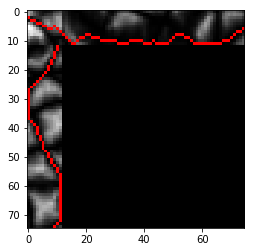

In [18]:
target = patch_3.copy()
target[:, :n_rc] = np.expand_dims(vert_err_cut, axis=2)
target[:n_rc, :] = np.expand_dims(hor_err_cut, axis=2)

nanmask = np.isnan(target)
target[nanmask] = 1
nimg = normalize_img(target)
nimg = np.where(nanmask, [1, 0, 0], nimg)
plt.imshow(nimg)

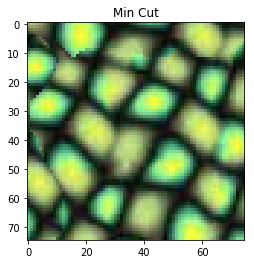

In [19]:
target = patch_3.copy()
hor_mask = (xx.T <= np.tile(np.expand_dims(left_min_path, 1), n_rc)).T
vert_mask = xx.T <=  np.tile(np.expand_dims(top_min_path, 1), n_rc)
target[:, :n_rc][vert_mask] = b1[vert_mask]
target[:n_rc, :][hor_mask] = b2[hor_mask]

plt.title('Min Cut')
plt.imshow(normalize_img(target))
plt.show()

In [20]:
def min_cut_block(block_size, overlap_size, top_right_patch, bot_left_patch, bot_right_patch):
    osz = overlap_size
    
    b1 = bot_left_patch[:, -osz:]
    b2 = top_right_patch[-osz:, :]
    b3 = bot_right_patch[:, :osz]
    b4 = bot_right_patch[:osz, :]
    
    # compute sum of squared deviations:
    error_surf_vert = np.sum((b1 - b3) ** 2, axis=2)
    error_surf_hor = np.sum((b2 - b4) ** 2, axis=2)
    
    # compute vertical and horizontal min error paths
    top_min_path = np.zeros((block_size), dtype=np.int)
    left_min_path = np.zeros((block_size), dtype=np.int)

    top_min_path[0] = np.argmin(error_surf_vert[0, :], axis=0)
    left_min_path[0] = np.argmin(error_surf_hor[:, 0], axis=0)
    
    for i in range(1, block_size):
        err_mid_v = error_surf_vert[i, :]
        err_mid_h = error_surf_hor[:, i]
        mid_v = err_mid_v[top_min_path[i - 1]]
        mid_h = err_mid_h[left_min_path[i - 1]]

        err_left = np.roll(error_surf_vert[i, :], 1, axis=0)
        err_top = np.roll(error_surf_hor[:, i], 1, axis=0)
        err_left[0] = err_top[0] = np.inf
        left = err_left[top_min_path[i - 1]]
        top = err_top[left_min_path[i - 1]]

        err_right = np.roll(error_surf_vert[i, :], -1, axis=0)
        err_bot = np.roll(error_surf_hor[:, i], -1, axis=0)
        err_right[-1] = err_bot[-1] = np.inf
        right = err_right[top_min_path[i - 1]]
        bot = err_bot[left_min_path[i - 1]]

        next_poss_pts_v = np.vstack((left, mid_v, right))
        next_poss_pts_h = np.vstack((top, mid_h, bot))

        new_pts_ind_v = top_min_path[i - 1] + (np.argmin(next_poss_pts_v, axis=0) - 1)
        new_pts_ind_h = left_min_path[i - 1] + (np.argmin(next_poss_pts_h, axis=0) - 1)
        top_min_path[i] = new_pts_ind_v
        left_min_path[i] = new_pts_ind_h
        
    yy, xx = np.meshgrid(np.arange(block_size), np.arange(osz))
    target = bot_right_patch.copy()
    hor_mask = (xx.T <= np.tile(np.expand_dims(left_min_path, 1), osz)).T
    vert_mask = xx.T <=  np.tile(np.expand_dims(top_min_path, 1), osz)
    target[:, :osz][vert_mask] = b1[vert_mask]
    target[:osz, :][hor_mask] = b2[hor_mask]
    
    return target

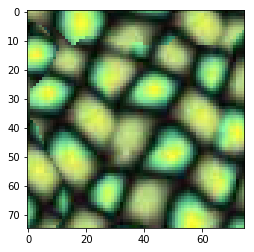

In [21]:
plt.imshow(normalize_img(min_cut_block(block_size, n_rc, patch_2, patch_1, patch_3)))